In [3]:
import numpy as np
import pandas as pd
import albumentations as A
import matplotlib.pyplot as plt
%matplotlib inline
import os, re, sys, random, shutil, cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras import applications, optimizers
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, ZeroPadding2D, Dropout

In [2]:
model = Model()
model.load_weights('InceptionResNetV2-UNet.keras')

In [4]:
class_dict_df = pd.read_csv('./input/class_dict.csv', index_col=False, skipinitialspace=True)
class_dict_df

,name,r,g,b
0,water,226,169,41
1,land,132,41,246
2,road,110,193,228
3,building,60,16,152
4,vegetation,254,221,58
5,unlabeled,155,155,155


In [5]:
data_gen_args = dict(rescale=1./255)
mask_gen_args = dict()
val_frames_datagen = ImageDataGenerator(**data_gen_args)
val_masks_datagen = ImageDataGenerator(**mask_gen_args)

In [6]:
label_names = list(class_dict_df.name)
label_codes = []
r = np.asarray(class_dict_df.r)
g = np.asarray(class_dict_df.g)
b = np.asarray(class_dict_df.b)

for i in range(len(class_dict_df)):
    label_codes.append(tuple([r[i], g[i], b[i]]))

label_codes, label_names

([(226, 169, 41),
  (132, 41, 246),
  (110, 193, 228),
  (60, 16, 152),
  (254, 221, 58),
  (155, 155, 155)],
 ['water', 'land', 'road', 'building', 'vegetation', 'unlabeled'])

In [7]:
code2id = {v: k for k, v in enumerate(label_codes)}
id2code = {k: v for k, v in enumerate(label_codes)}

name2id = {v: k for k, v in enumerate(label_names)}
id2name = {k: v for k, v in enumerate(label_names)}

In [8]:
def rgb_to_onehot(rgb_image, colormap=id2code):
    '''Function to one hot encode RGB mask labels
        Inputs: 
            rgb_image - image matrix (eg. 256 x 256 x 3 dimension numpy ndarray)
            colormap - dictionary of color to label id
        Output: One hot encoded image of dimensions (height x width x num_classes) where num_classes = len(colormap)
    '''
    num_classes = len(colormap)
    shape = rgb_image.shape[:2]+(num_classes,)
    encoded_image = np.zeros(shape, dtype=np.int8)
    for i, cls in enumerate(colormap):
        encoded_image[:, :, i] = np.all(rgb_image.reshape(
            (-1, 3)) == colormap[i], axis=1).reshape(shape[:2])
    return encoded_image


def onehot_to_rgb(onehot, colormap=id2code):
    '''Function to decode encoded mask labels
        Inputs: 
            onehot - one hot encoded image matrix (height x width x num_classes)
            colormap - dictionary of color to label id
        Output: Decoded RGB image (height x width x 3) 
    '''
    single_layer = np.argmax(onehot, axis=-1)
    output = np.zeros(onehot.shape[:2]+(3,))
    for k in colormap.keys():
        output[single_layer == k] = colormap[k]
    return np.uint8(output)

In [9]:
def ValAugmentGenerator(val_images_dir, val_masks_dir, seed=1, batch_size=8, target_size=(512, 512)):
    '''Validation Image data generator
        Inputs: 
            seed - seed provided to the flow_from_directory function to ensure aligned data flow
            batch_size - number of images to import at a time
            val_images_dir - validation images directory
            val_masks_dir - validation masks directory
            target_size - tuple of integers (height, width)

        Output: Decoded RGB image (height x width x 3) 
    '''
    val_image_generator = val_frames_datagen.flow_from_directory(
        val_images_dir,
        batch_size=batch_size,
        seed=seed,
        target_size=target_size)

    val_mask_generator = val_masks_datagen.flow_from_directory(
        val_masks_dir,
        batch_size=batch_size,
        seed=seed,
        target_size=target_size)

    while True:
        X1i = next(val_image_generator)
        X2i = next(val_mask_generator)

        # One hot encoding RGB images
        mask_encoded = [rgb_to_onehot(X2i[0][x, :, :, :], id2code)
                        for x in range(X2i[0].shape[0])]

        yield X1i[0], np.asarray(mask_encoded)

In [10]:
testing_gen = ValAugmentGenerator(val_images_dir='./input/test/images', val_masks_dir='./input/test/masks', target_size=(512, 512))

In [11]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_inception_resnetv2_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained InceptionResNetV2 Model """
    encoder = InceptionResNetV2(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = encoder.get_layer("input_layer").output           ## (512 x 512)

    s2 = encoder.get_layer("activation").output        ## (255 x 255)
    s2 = ZeroPadding2D(( (1, 0), (1, 0) ))(s2)         ## (256 x 256)

    s3 = encoder.get_layer("activation_3").output      ## (126 x 126)
    s3 = ZeroPadding2D((1, 1))(s3)                     ## (128 x 128)

    s4 = encoder.get_layer("activation_74").output      ## (61 x 61)
    s4 = ZeroPadding2D(( (2, 1),(2, 1) ))(s4)           ## (64 x 64)

    """ Bridge """
    b1 = encoder.get_layer("activation_161").output     ## (30 x 30)
    b1 = ZeroPadding2D((1, 1))(b1)                      ## (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)
    
    """ Output """
    dropout = Dropout(0.3)(d4)
    outputs = Conv2D(6, 1, padding="same", activation="softmax")(dropout)

    model = Model(inputs, outputs, name="InceptionResNetV2-UNet")
    return model

In [12]:
model = build_inception_resnetv2_unet(input_shape = (512, 512, 3))

In [13]:
model.load_weights('InceptionResNetV2-UNet.keras')

In [14]:
for i in testing_gen:
    batch_img, batch_mask = i
    pred_all = model.predict(batch_img)
    
    for j in range(0, batch_img.shape[0]):
        fig, ax = plt.subplots(1, 3, figsize=(10, 5))
        ax[0].imshow(batch_img[j])
        ax[1].imshow(onehot_to_rgb(batch_mask[j]))
        ax[2].imshow(onehot_to_rgb(pred_all[j]))
    
    break

Found 142 images belonging to 1 classes.
Found 142 images belonging to 1 classes.


KeyboardInterrupt: 

In [94]:
def change_contrast(img, level):
    factor = (259 * (level + 255)) / (255 * (259 - level))
    def contrast(c):
        return 128 + factor * (c - 128)
    return img.point(contrast)

In [105]:
custom = os.listdir('./custom/')

for i in custom:
    if i == 'contrast':
        continue
    img = Image.open('./custom/' + i)
    img = img.resize((512, 512))
    change_contrast(img, 60).save('./custom/contrast/' + i)

In [106]:
custom_gen = ValAugmentGenerator(val_images_dir='./custom', val_masks_dir='./custom', target_size=(512, 512))

Found 6 images belonging to 1 classes.
Found 6 images belonging to 1 classes.


1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step


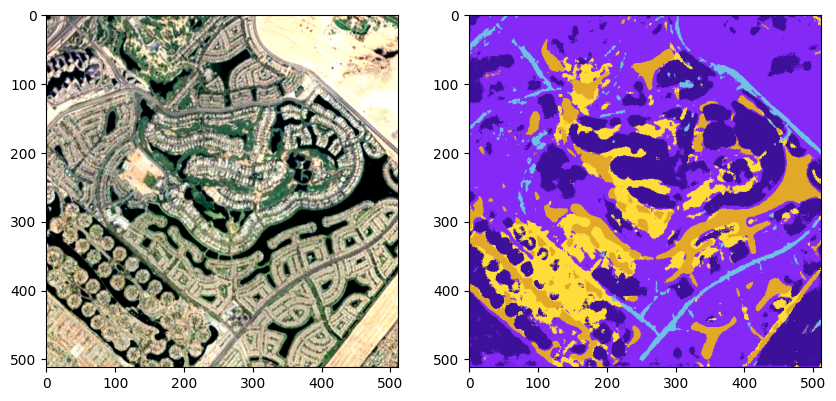

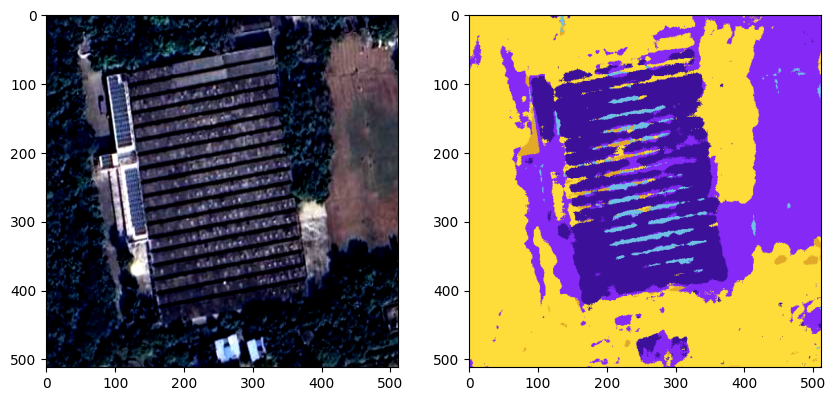

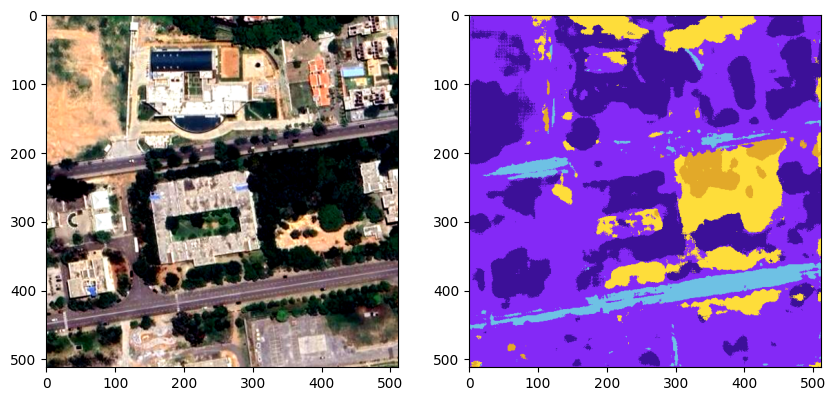

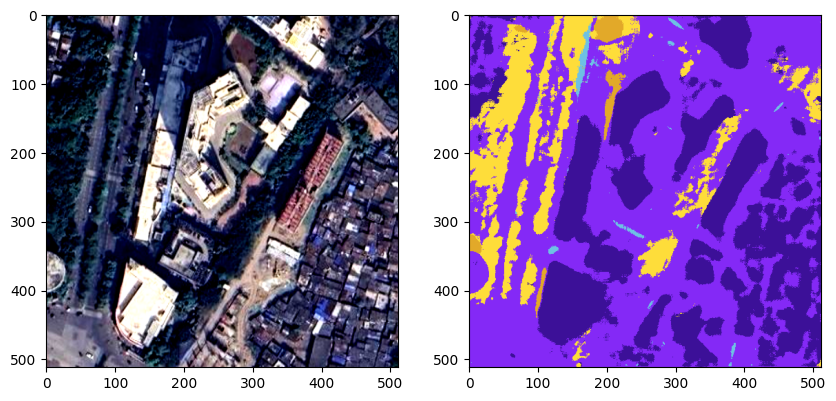

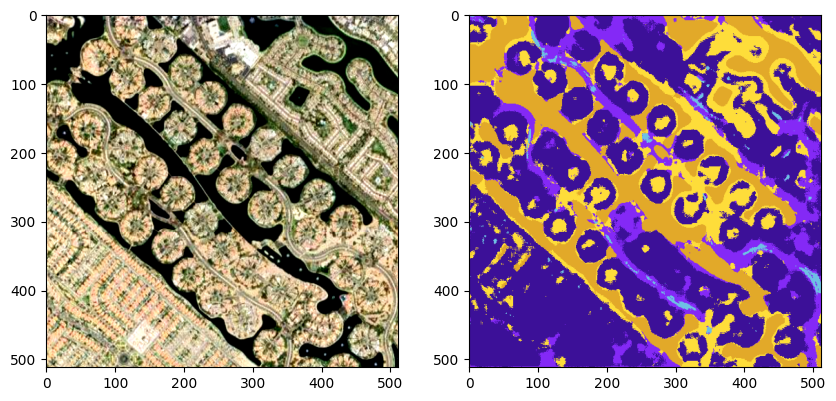

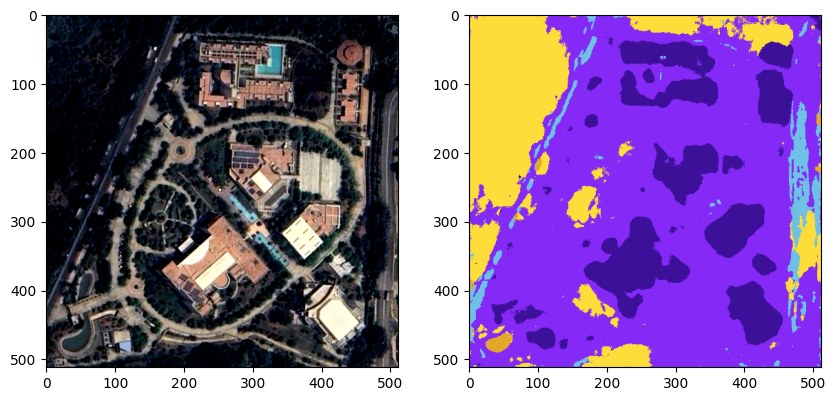

In [107]:
while True:
    X1i = next(custom_gen)
    pred_all = model.predict(X1i[0])
    
    for j in range(0, X1i[0].shape[0]):
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(X1i[0][j])
        ax[1].imshow(onehot_to_rgb(pred_all[j]))
        
    break
    